In [143]:
# ALGORYTM Z "Approximation of piecewise Hölder functions from inexact information"

# PARAMETRY ALGORYTMU:
# h = T/m, gdzie m >= 2r + 1   <--- initial resolution of the mesh
# 0 < w < (r + 1) * h

In [144]:
# Kroki algorytmu:
# 1. aproksymacja punktu osobliwego s_f
#   1a. siatka regularna (o długości h) oraz różnice dzielne użyte są do lokalizacji s_f na przedziale [u_1, v_1] (o długości (r+1) * h)
#   1b. zawęzenie przedziałów z 1a do [u_2, v_2] przy użyciu wielomianów ekstrpolacyjnych p_neg i p_pos
#   1c. wyprodukowanie przedziału [u_3, v_3] zawierającego się (lub równego) [u_2, v_2], w którym różnica |p_pos - p_neg| jest nierosnąca na [u_3, ksi] i niemalejąca na [ksi, v_3], gdzie ksi jest finalną aproksymacją s_f
# 2.

In [145]:
import numpy as np

In [146]:
print(np.finfo(np.longdouble))


Machine parameters for float64
---------------------------------------------------------------
precision =  15   resolution = 1.0000000000000001e-15
machep =    -52   eps =        2.2204460492503131e-16
negep =     -53   epsneg =     1.1102230246251565e-16
minexp =  -1022   tiny =       2.2250738585072014e-308
maxexp =   1024   max =        1.7976931348623157e+308
nexp =       11   min =        -max
---------------------------------------------------------------



In [147]:
T = 2 * np.pi + 0.5

def f(x):
    if 0 <= x < np.pi:
        return np.sin(x - np.pi)
    if np.pi <= x <= 2 * np.pi + 0.5:
        return np.sin(x - np.pi - 0.5)


In [148]:
T = 3 * np.pi

def f(x):
    if 0 <= x < np.pi:
        return np.sin(x)
    if np.pi <= x <= 3 * np.pi:
        return np.sin(x - np.pi)

In [149]:
from math import fsum

def prod(i, r, t, j):
    product = 1.0
    for k in range(i, i+r+1):
        if k == j:
            continue
        product *= 1 / (t[k] - t[j])
    return product


def d_noisy2(i, r, t, y):
    '''t : array of data points t_i, ... , t_{i+r+1}
       y : array of y_j = f(t_j) + e_j  '''
    t.astype('float64')
    y.astype('float64')

    array = [y[j] * prod(i, r, t, j) for j in range(i, i+r+1)]
    # print(array)
    return fsum(array)
    # return np.sum(np.sort([y[j] * prod(i, r, t, j) for j in range(i, i+r+1)]))

In [150]:
def d_noisy(i, r, t, y):
    '''t : array of data points t_i, ... , t_{i+r+1}
       y : array of y_j = f(t_j) + e_j  '''
    t.astype('float64')
    y.astype('float64')

    sum = np.float64(0.0)
    for j in range(i, i+r+1):

        product = 1.0
        for k in range(i, i+r+1):
            if k == j:
                continue
            product *= 1 / (t[k] - t[j])

        sum += y[j] * product

    return sum

In [151]:
delta = 10e-4
r = 2
m = 1000

In [152]:
# Step 0 (initialization of algorithm's constants and function evaluations)
h = T / m
w = -1.0 * np.random.uniform(-(r + 1) * h, 0) # multiply by -1 because we need interval (0, (r + 1) * h]
# print("h = {}".format(h))
# for i in range(0, m + 1):
#     print("t_{} = {}".format(i, i*h))
t = np.linspace(0, T, m+1, dtype='float64') # czyli mamy m+1 wezlów postaci t[0], ... , t[m]
e = np.random.uniform(-delta, delta, m+1)
y = np.array([f(t[j]) + e[j] for j in range(0, m+1)])

In [153]:
np.set_printoptions(precision = 8, suppress=True)
print(t)
print(e)
print(y)

[0.         0.00942478 0.01884956 ... 9.4059284  9.41535318 9.42477796]
[-0.0002014  -0.00086472  0.00048322 ...  0.0001308  -0.00009349
 -0.00094678]
[-0.0002014   0.00855992  0.01933166 ... -0.01871764 -0.00951813
 -0.00094678]


In [154]:
# Step 1
i_max = np.argmax([d_noisy(i, r, t, y) for i in range(0, m-r)]) # innaczej liczone roznice dzielone
u_1 = t[i_max]
v_1 = t[i_max + r +1]
print("i_max = {}  u_1 = {}  v_1 = {}".format(i_max, t[i_max], t[i_max + r +1]))

i_max = 332  u_1 = 3.129026282975434  v_1 = 3.157300616857742


In [155]:
# Step 1
i_max = np.argmax([d_noisy2(i, r, t, y) for i in range(0, m-r)])
u_1 = t[i_max]
v_1 = t[i_max + r +1]
print("i_max = {}  u_1 = {}  v _1 = {}".format(i_max, t[i_max], t[i_max + r +1]))

i_max = 332  u_1 = 3.129026282975434  v _1 = 3.157300616857742


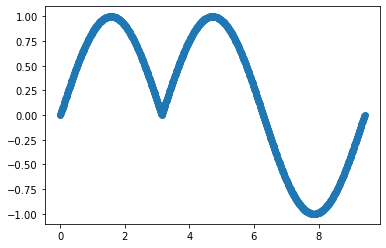

In [156]:
import matplotlib.pyplot as plt

plt.scatter(t,y)

In [157]:
from scipy import interpolate

In [158]:
# Step 2
p_neg = interpolate.interp1d(
    t[i_max - r:i_max + 1],
    y[i_max - r:i_max + 1],
    fill_value="extrapolate"
)
p_pos = interpolate.interp1d(
    t[i_max + r + 1: i_max + 2 * r + 1 + 1],
    y[i_max + r + 1: i_max + 2 * r + 1 + 1],
    fill_value="extrapolate"
)


In [159]:
# Step 2 continued
u = u_1
v = v_1

while v - u > w:
    z = np.array([u + j * (v - u) / (r + 2) for j in range(1, r + 2)])
    dif = np.abs(p_pos(z) - p_neg(z))
    j_max = np.argmax(dif)

    # tu chyba nie powinno byc bezposrednio f tylko f_noisy = f() + e
    if np.abs(f(z[j_max]) - p_neg(z[j_max])) <= np.abs(f(z[j_max]) - p_pos(z[j_max])):
        u = z[j_max]
    else:
        v = z[j_max]

u_2 = u
v_2 = v

In [160]:
print(u_1, v_1)
print(u_2, v_2)

3.129026282975434 3.157300616857742
3.1343277205783666 3.150232033387165


In [161]:
from scipy.optimize import minimize_scalar

In [162]:
def fun(x):
    return -1 * np.abs(p_neg(x) - p_pos(x))

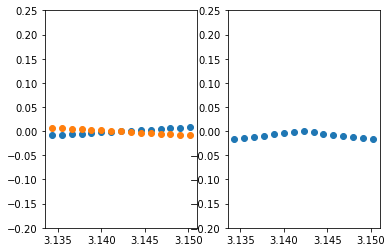

In [163]:
interval = np.linspace(u_2, v_2, num=15)

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].scatter(interval, p_pos(interval))
ax[0].scatter(interval, p_neg(interval))

ax[1].scatter(interval, fun(interval))

plt.setp(ax, ylim=(-0.20, 0.25))
plt.show()

result = minimize_scalar(fun=fun, bracket=(u,v))

print("if success = {}  z_max = {}".format(result.success, result.x))

In [164]:
# Step 3
u = u_2
v = v_2


z_max = [0.0]   # it list only because we need to modify it inside of function (we cannot modify number)
while True:
    result = minimize_scalar(fun=fun, bracket=(u,v))
    if result.success == False:
        break
    
    z_max = result.x
    if np.abs(f(z_max) - p_neg(z_max)) <= np.abs(f(z_max) - p_pos(z_max)):
        u = z
    else:
        v = z

u_3 = u
v_3 = v

In [165]:
print(u_1, v_1)
print(u_2, v_2)
print(u_3, v_3)

3.129026282975434 3.157300616857742
3.1343277205783666 3.150232033387165
3.1343277205783666 3.150232033387165


In [166]:
# Final approximation (i use custom mesh to find argmin)
mesh = np.arange(u_1, v_1, step=0.0005)
x_array = [np.abs(p_pos(k) - p_neg(k)) for k in mesh]
ksi = mesh[np.argmin(x_array)] # ksi is on x-asix

In [167]:
print(ksi)

3.142026282975438


In [168]:
# print(z)
# print(t[i_max:i_max + r + 1])

# Final approximation    <--- wedlug mnie to jest najlogiczniejsze, gdyz dla tych wezłow juz wczesniej liczylismy wartosci funkcji(możnaby nawet gdzies je zapisac i uzyc jeszcze raz zeby nie narazac sie na powtórne liczenie w arytmetyce fl, jednak z drugiej strony tych ovliczonych wartości fun, nie jest duzo)
# x = [np.abs(p_pos(k) - p_neg(k)) for k in z]
# ksi = np.argmin(x)
# print(x)
# print(ksi)

# Final approximation
# x = [np.abs(p_pos(k) - p_neg(k)) for k in t[i_max:i_max + r + 1]]
# ksi = np.argmin(x)
# print(x)
# print(ksi)

In [169]:
# mamy "przedziały" na osi x-ów:
# t[0],...,t[i_max-1]      u_1,...,mesh[ksi]   mesh[ksi],...,v_1   t[i_max + r + 1 + 1],...,T
# u_1 = t[i_max]   v_1 = t[i_max + r + 1]

# finding closest value to ksi in orginal mesh
k = 0
while ksi > t[k]:
    k += 1

k = k if np.abs(ksi - t[k]) < np.abs(ksi - t[k+1]) else k+1

x_array = np.append(t[:i_max-1], t[i_max:k], )

In [170]:
# Final interpolating polynomial

polynomial1 = interpolate.interp1d(
            t[:i_max + 1],
            y[:i_max + 1])

polynomial2 = interpolate.interp1d(
            t[i_max + r + 1:],
            y[i_max + r + 1:])

def final_polynomial(x):
    if (t[0] <= x).all() and (x < u_1).all():
        return polynomial1(x)
    if (u_1 <= x).all() and (x < ksi).all():
        return p_neg(x)
    if (ksi <= x).all() and (x < v_1).all():
        return p_pos(x)
    if (v_1 <= x).all() and (x <= t[m]).all():
        return polynomial2(x)

In [171]:
values = []
for x in t:
    values += [final_polynomial(x)]

values = np.array(values)

In [172]:
t.shape

(1001,)

In [173]:
values.shape

(1001,)

In [174]:
print(values)

[-0.0002014   0.00855992  0.01933166 ... -0.01871764 -0.00951813
 -0.00094678]


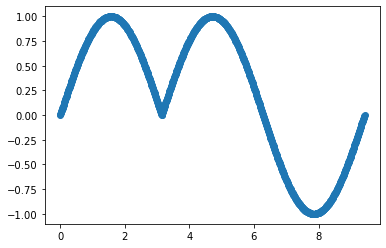

In [175]:
plt.scatter(t,values)

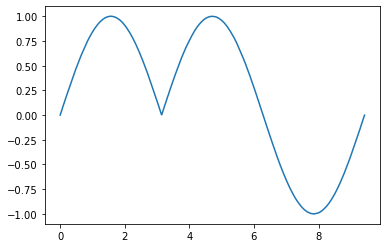

In [176]:
plt.plot(t,values)
plt.show()